# **MÔ HÌNH DỰ ĐOÁN PHIM**

Vấn đề: Dự đoán Ratings của phim dựa trên các thông tin được cho trước, bao gồm thời lượng, giới hạn độ tuổi, thể loại, số lượt đề cử, số lần thắng giải và số lượt bình chọn.

Mô hình 1: RandomForestRegressor

Mô hình 2: GradientBoosting

Mô hình 3: LinearRegression

## 1. Import thư viện cần thiết

In [59]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
df = pd.read_csv('../Data/movie_data.csv')
df.head()

,Title,Release time,Age rating,Runtime,Language,IMDb Rating,IMDb Votes,Action,Adventure,Animation,...,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,Win,Nomination,Age rating quantification
0,Goon Squad,2024-01-18,NC-17,83.0,English,6.1,12430.6658,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,5
1,The Phantom Warrior,2024-02-20,R,83.0,English,2.6,532.0000,False,True,False,...,False,True,False,False,False,False,False,0.0,0.0,4
2,Beyond the Lake,2024-01-26,G,98.0,English,6.1,31.0000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,1
3,Crimes of Fashion: Killer Clutch,2024-03-15,PG,84.0,"English, French",5.8,503.0000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,2
4,Love on the Danube: Love Song,2024-09-10,G,84.0,English,5.8,175.0000,False,False,False,...,True,False,False,False,False,False,False,0.0,0.0,1


## 2. Xác định input và output của bài toán

- Output: Vì nhóm muốn dự đoán đánh giá cho bộ phim, nên output sẽ là `IMDb Rating`. Cột này đã có sẵn trong bộ dữ liệu.
- Input: Gồm các thông tin của 1 bộ phim. Theo phần tìm hiểu trong Exploring và Eda, nhóm quyết định sẽ giữ phần lớn các cột nhưng sẽ bỏ 1 số cột sau:
    + Cột Title và Release time: Hai cột này có phân lớp rất mạnh, với các giá trị trong cột Title này đều là phân biệt.
    + Cột Age rating: Đã được mã hóa thành các giá trị có thứ tự trong cột Age rating quantification.
    + Cột Language: Có phân lớp khá mạnh với khoảng hơn 50 ngôn ngữ khác nhau và ngôn ngữ chủ yếu vẫn là tiếng Anh. 

In [61]:
data = df.copy()
data.columns

Index(['Title', 'Release time', 'Age rating', 'Runtime', 'Language',
       'IMDb Rating', 'IMDb Votes', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western',
       'Win', 'Nomination', 'Age rating quantification'],
      dtype='object')

In [62]:
data = data.iloc[:, 3:]
data = data.drop(columns=['Language'])
data = data[[col for col in data.columns if col != 'IMDb Rating'] + ['IMDb Rating']]
data.columns

Index(['Runtime', 'IMDb Votes', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western',
       'Win', 'Nomination', 'Age rating quantification', 'IMDb Rating'],
      dtype='object')

## 3. Tiền xử lý dữ liệu

- Xử lý outliers trong cột IMDb Rating: Như đã trực quan trong phần Exploring, dữ liệu của cột IMDb Rating có khá nhiều outliers là những bộ phim có điểm số rất cao hoặc rất thấp, để đơn giản hóa việc xử lý, nhóm lựa chọn loại bỏ các giá trị outliers này.

In [63]:
def resolve_outliers(col: pd.Series):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR

    return lower, upper

lower_limit, upper_limit = resolve_outliers(df['IMDb Rating'])
outlier_data = data[(data['IMDb Rating'] < lower_limit) | (data['IMDb Rating'] > upper_limit)]
data = data[(data['IMDb Rating'] >= lower_limit) & (data['IMDb Rating'] <= upper_limit)]

In [64]:
outlier_data

,Runtime,IMDb Votes,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Sci-Fi,Short,Sport,Thriller,War,Western,Win,Nomination,Age rating quantification,IMDb Rating
1,83.0,532.0,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,0.0,0.0,4,2.6
14,80.0,308.0,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,0.0,0.0,2,2.1
15,90.0,2245.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.0,0.0,4,3.3
28,94.0,563.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.0,0.0,4,2.6
44,86.0,3015.0,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,0.0,0.0,1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,89.0,19.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,0.0,0.0,1,8.9
1675,97.0,960.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.0,0.0,4,3.4
1676,93.0,1352.0,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,0.0,0.0,4,3.9
1691,93.0,1526.0,True,True,False,False,True,False,False,False,...,False,False,False,False,False,False,0.0,0.0,3,3.8


In [65]:
y = data['IMDb Rating']
X = data.iloc[:, :-1]

/home/uyennguyen/miniconda3/envs/min_ds-env2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


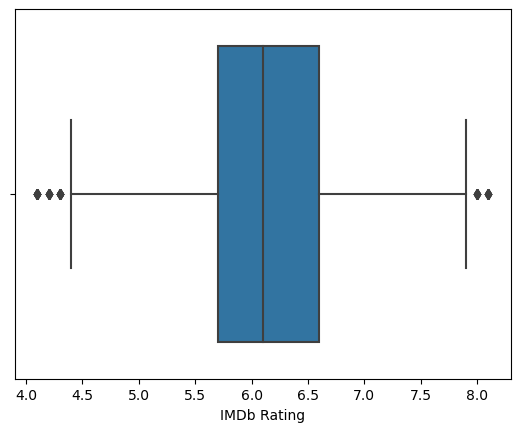

In [66]:
sns.boxplot(y);

## 4. Phân chia các tập dữ liệu

- Trong phần này, nhóm sẽ chia dữ liệu thành 3 tập là train 70%, test 15% và valid 15%.

In [67]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

- Kiểu dư liệu hiện tại của các cột input:

In [68]:
X.dtypes

Runtime                      float64
IMDb Votes                   float64
Action                          bool
Adventure                       bool
Animation                       bool
Biography                       bool
Comedy                          bool
Crime                           bool
Documentary                     bool
Drama                           bool
Family                          bool
Fantasy                         bool
History                         bool
Horror                          bool
Music                           bool
Musical                         bool
Mystery                         bool
Romance                         bool
Sci-Fi                          bool
Short                           bool
Sport                           bool
Thriller                        bool
War                             bool
Western                         bool
Win                          float64
Nomination                   float64
Age rating quantification      int64
d

## 5. Áp dụng mô hình

### a) Random Forest Regressor

- Để tối ưu siêu tham số khi thực hiện train dữ liệu, nhóm lựa chọn 1 phương pháp đơn giản là sử dụng công cụ GridSearchCV của sklearn để thực hiện tìm kiếm các siêu tham số tốt nhất của mô hình rồi thử nghiệm trên tập valid.

- Đồng thời, vì dữ liệu hạn chế nên nhóm sử dụng phương pháp k-fold cross validation với k = 5 để giảm thiểu overfitting. 

In [69]:
eval_values = {}

In [70]:
rf_model = RandomForestRegressor(random_state=42)

hyperparameters = {  
    'n_estimators': [10, 20, 50, 100, 150],  
    'max_depth': [None, 10, 20, 30],   
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt'], 
}  

grid_search = GridSearchCV(rf_model, hyperparameters, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

- Kiểm tra trên tập valid

In [71]:
y_prediction_rf = best_rf_model.predict(X_valid)
mae_rf = mean_absolute_error(y_valid, y_prediction_rf)
rmse_rf = np.sqrt(mean_squared_error(y_valid, y_prediction_rf))
eval_values['Random Forest'] = [mae_rf, rmse_rf]

### b) Gradient Boosting

- Tương tự thuật toán Random Forest, nhóm sử dụng GridSearchCV tối ưu siêu tham số nhiều lần với 5-fold cross validation để giảm overfitting.

In [72]:
gb_model = GradientBoostingRegressor(random_state=42)

param_grid = {  
    'n_estimators': [50, 100, 150, 200],          
    'learning_rate': [0.01, 0.1, 0.15, 0.2],      
    'max_depth': [3, 5, 7],                       
    'subsample': [0.6, 0.8, 1.0]                 
}  

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,  
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_gb_model = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


- Thử nghiệm trên tập valid

In [73]:
y_prediction_gb = best_gb_model.predict(X_valid)
mae_gb = mean_absolute_error(y_valid, y_prediction_gb)
rmse_gb = np.sqrt(mean_squared_error(y_valid, y_prediction_gb))
eval_values['Gradient Boosting'] = [mae_gb, rmse_gb]

### c) Linear Regression:

In [74]:
X.select_dtypes(exclude=['bool']).describe()

,Runtime,IMDb Votes,Win,Nomination,Age rating quantification
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,95.476426,12289.992976,1.430634,3.085374,3.108600
std,25.329783,36666.736143,9.208657,21.808589,1.041902
min,3.000000,5.000000,0.000000,0.000000,1.000000
25%,84.000000,264.000000,0.000000,0.000000,2.000000
50%,95.491188,1462.000000,0.000000,0.000000,3.000000
75%,109.000000,12430.665800,0.000000,0.000000,4.000000
max,280.000000,571413.000000,206.000000,429.000000,5.000000


- Chuẩn hóa dữ liệu: Dữ liệu của cột Runtime, IMDb Votes, Win và Nomination có khá nhiều giá trị outliers và cũng có miền giá trị khá rộng, vì vậy trước khi áp dụng vào mô hình Linear Regression, nhóm sẽ áp dụng Robust Scaler để chuẩn hóa dữ liệu các cột này. 

In [75]:
from sklearn.preprocessing import RobustScaler  

robust_scaler = RobustScaler()  
X_train[['Runtime', 'IMDb Votes', 'Win', 'Nomination']] = robust_scaler.fit_transform(X_train[['Runtime', 'IMDb Votes', 'Win', 'Nomination']]) 
X_valid[['Runtime', 'IMDb Votes', 'Win', 'Nomination']] = robust_scaler.fit_transform(X_valid[['Runtime', 'IMDb Votes', 'Win', 'Nomination']])

In [76]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [77]:
y_prediction_lr = lr_model.predict(X_valid)
mae_lr = mean_absolute_error(y_valid, y_prediction_lr)
rmse_lr = np.sqrt(mean_squared_error(y_valid, y_prediction_lr))
eval_values['Linear Regression'] = [mae_lr, rmse_lr]

## 6. So sánh kết quả các mô hình trên tập valid

### a) So sánh độ chính xác các mô hình trên tập valid

In [79]:
cols = ['MAE', 'RMSE']

eval_values_df = pd.DataFrame.from_dict(eval_values, orient='index', columns=cols)  
eval_values_df.index.name = 'Model'  
eval_values_df

,MAE,RMSE
Model,,
Random Forest,0.508080,0.675905
Gradient Boosting,0.511857,0.683523
Linear Regression,0.569695,0.744806


### b) Nhận xét: 